**Implementation of the original Grad-CAM paper https://arxiv.org/abs/1610.02391**

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target class flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the class. 

This results in a coarse saliency map, which can then be resized to the
original input image size to render a class-discriminative saliency map.

**Goal: To see where our trained model is paying attention to and see if the predictions trained on class labels have anything to do with the real bounding boxes.**

**This notebook uses two network trained in my two seperate notebooks, one trained to classify opacity vs None (Image level classes), the other, for 4 classes of 'Negative for Pneumonia' 'Typical Appearance' 'Indeterminate Appearance' 'Atypical Appearance' (Study level classes)**

[First Notebook](https://www.kaggle.com/sinamhd9/image-label-classification-opacity-vs-none)

[Second Notebook](https://www.kaggle.com/sinamhd9/classification-model)

**Note that the reference notebooks may get updated to achieve better accuracy based on the insights from this notebook**

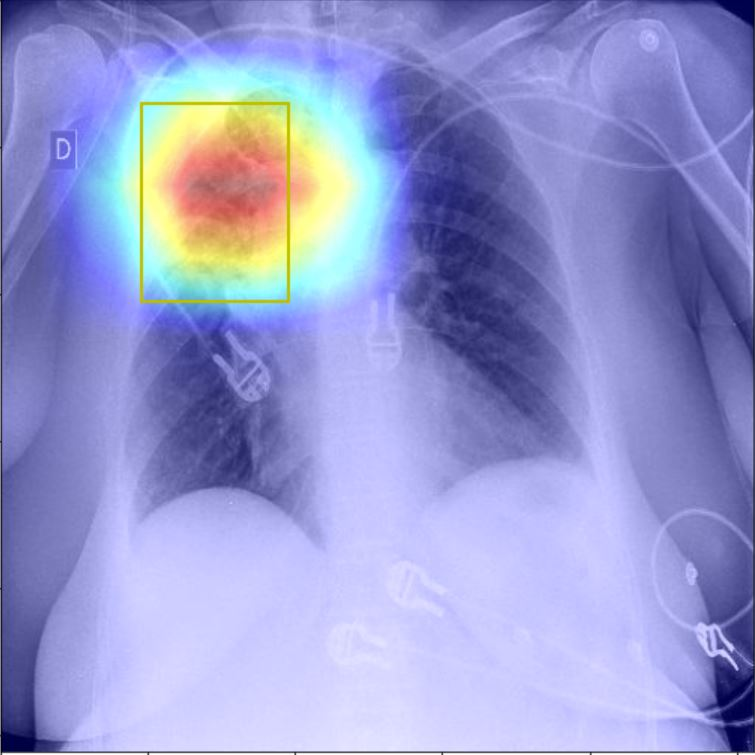

# Imports

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import pandas as pd 
from matplotlib.patches import Rectangle
from ast import literal_eval
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
from skimage.transform import resize
from skimage import exposure 
import os

# Same processing as original notebooks

In [ ]:
pip install dicom2jpg

In [ ]:
pip install pydicom

In [ ]:
pip install pypng

In [ ]:
import numpy as np
import png, os, pydicom

source_folder = r'/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
output_folder = r'/kaggle/working/newtrain/'


def dicom2png(source_folder, output_folder):
    list_of_files = os.listdir(source_folder)
    for file in list_of_files:
        try:
            ds = pydicom.dcmread(os.path.join(source_folder,file))
            shape = ds.pixel_array.shape

            # Convert to float to avoid overflow or underflow losses.
            image_2d = ds.pixel_array.astype(float)

            # Rescaling grey scale between 0-255
            image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

            # Convert to uint
            image_2d_scaled = np.uint8(image_2d_scaled)

            # Write the PNG file
            with open(os.path.join(output_folder,file)+'.png' , 'wb') as png_file:
                w = png.Writer(shape[1], shape[0], greyscale=True)
                w.write(png_file, image_2d_scaled)
        except:
            print('Could not convert: ', file)


dicom2png(source_folder, output_folder)

In [2]:
df_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
df_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
df_study['id'] = df_study['id'].str.replace('_study',"")
df_study.rename({'id': 'StudyInstanceUID'},axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')
df_train.loc[df_train['Negative for Pneumonia']==1, 'study_label'] = 'negative'
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)
df_train['id'] = df_train['id'].str.replace('_image', '.jpg')
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_size = pd.read_csv('../input/covid-jpg-512/size.csv')
df_train = df_train.merge(df_size, on='id')
df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity,3488,4256,train
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,negative,none,2320,2832,train
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity,2544,3056,train


In [3]:
df_train['image_label']=df_train['image_label'].replace('opacity',1)


In [4]:
df_train['image_label']=df_train['image_label'].replace('none',0)

In [5]:
import pandas as pd
import ast
import numpy as np

# Sample DataFrame creation with NaN values
data = {
    'boxes': [
        "[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",
        np.nan,
        "[{'x': 100.0, 'y': 200.0, 'width': 300.0, 'height': 400.0}]",
        "Invalid Data"
    ]
}
df = pd.DataFrame(data)

# Function to extract the first x, y, width, and height
def extract_first_values(box_str):
    if pd.isna(box_str):
        return pd.Series([np.nan, np.nan, np.nan, np.nan])  # Return NaN if the value is NaN
    try:
        boxes_list = ast.literal_eval(box_str)  # Convert string to list of dicts
        # Extract the first item if available
        first_box = boxes_list[0] if boxes_list else {}
        return pd.Series([first_box.get('x', np.nan), first_box.get('y', np.nan),
                          first_box.get('width', np.nan), first_box.get('height', np.nan)])
    except (ValueError, SyntaxError) as e:
        # Handle any errors in data conversion
        return pd.Series([np.nan, np.nan, np.nan, np.nan])

# Apply the function to the DataFrame
df_train[['x', 'y', 'width', 'height']] = df_train['boxes'].apply(extract_first_values)




In [6]:
df_train.head()

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split,x,y,width,height
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,1,3488,4256,train,789.28836,582.43035,1026.65662,1917.30292
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,negative,0,2320,2832,train,NaN,NaN,NaN,NaN
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,1,2544,3056,train,677.42216,197.97662,867.79767,999.78214
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,atypical,1,3520,4280,train,2729.00000,2181.33331,948.00012,604.00000
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,typical,1,2800,3408,train,623.23328,1050.00000,714.00000,1106.00000


In [6]:
df_train['image_label']=df_train['image_label'].astype(str)

In [7]:
df_train.head()

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split,x,y,width,height
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,1,3488,4256,train,789.28836,582.43035,1026.65662,1917.30292
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,negative,0,2320,2832,train,NaN,NaN,NaN,NaN
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,1,2544,3056,train,677.42216,197.97662,867.79767,999.78214
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,atypical,1,3520,4280,train,2729.00000,2181.33331,948.00012,604.00000
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,typical,1,2800,3408,train,623.23328,1050.00000,714.00000,1106.00000


In [7]:
def preprocess_image(x):
    x=x.astype("float32")
    x/=255.
    x-=0.5
    x*=2.
    return x

img_size = 299
batch_size = 16

image_generator = ImageDataGenerator(
        validation_split=0.2,
        #rotation_range=20,
        horizontal_flip = True,
        zoom_range = 0.1,
        #shear_range = 0.1,
        brightness_range = [0.8, 1.1],
        fill_mode='nearest',
        preprocessing_function=preprocess_image
)

image_generator_valid = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_image)

train_generator1 = image_generator.flow_from_dataframe(
        dataframe = df_train,
        directory='/kaggle/input/covid-jpg-512/train',
        x_col = 'id',
        y_col =  'image_label',  
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        subset='training', seed = 23) 

valid_generator1 = image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='/kaggle/input/covid-jpg-512/train',
    x_col = 'id',
    y_col = 'image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation', shuffle=False, seed=23) 
'''
train_generator2 = image_generator.flow_from_dataframe(
        dataframe = df_train,
        directory='../input/covid-jpg-512/train',
        x_col = 'id',
        y_col =  'study_label',  
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training', seed = 23) 

valid_generator2 = image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='../input/covid-jpg-512/train',
    x_col = 'id',
    y_col = 'study_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation', shuffle=False, seed=23) 
'''

Found 5068 validated image filenames belonging to 2 classes.
Found 1266 validated image filenames belonging to 2 classes.


"\ntrain_generator2 = image_generator.flow_from_dataframe(\n        dataframe = df_train,\n        directory='../input/covid-jpg-512/train',\n        x_col = 'id',\n        y_col =  'study_label',  \n        target_size=(img_size, img_size),\n        batch_size=batch_size,\n        subset='training', seed = 23) \n\nvalid_generator2 = image_generator_valid.flow_from_dataframe(\n    dataframe = df_train,\n    directory='../input/covid-jpg-512/train',\n    x_col = 'id',\n    y_col = 'study_label',\n    target_size=(img_size, img_size),\n    batch_size=batch_size,\n    class_mode='binary',\n    subset='validation', shuffle=False, seed=23) \n"

In [30]:
def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img

# Main Grad-CAM algorithm

In [52]:
def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam)) 
    return L_gradCam.numpy()

# Blend

Superimposing gradCAM heatmap on the original image

In [ ]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

# Loading model of notebook 1 (Opacity vs None)

## Results

In [8]:
pip install saliency 

     |████████████████████████████████| 86 kB 2.4 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import ast
# From our repository.
import saliency.core as saliency
import json

%matplotlib inline

In [9]:
df_train['id'] = df_train['id'].str.replace('.jpg', '')

In [10]:
X_test=df_train[['id']]
y_test=df_train[['image_label']]



In [11]:
X_test.columns = ['name']
y_test.columns = ['label']

test_df = pd.concat([X_test,y_test],axis=1)

In [12]:
test_df.head()

,name,label
0,000a312787f2,1
1,000c3a3f293f,0
2,0012ff7358bc,1
3,001398f4ff4f,1
4,001bd15d1891,1


In [13]:
import imageio

X_test = np.asarray([imageio.imread(os.path.join('/kaggle/input/covid-jpg-512/train/', f"{_}.jpg")) for _ in test_df.name])

In [14]:
X_test = np.expand_dims(X_test, axis=-1)



In [15]:
X_test=preprocess_image(X_test)

In [16]:
X_test2 = np.concatenate((X_test,X_test,X_test),axis=3)

In [18]:


from collections import defaultdict
bb_coords = []
bb_coords2 = []
counts = []
counts2 = []
scores = defaultdict(list)

In [19]:
import random
test_ids = np.asarray(list(test_df["name"]))
y_test = np.asarray(list(test_df["label"]))
scores = defaultdict(list)

mask = np.zeros(len(X_test2))#select 100 images from the test set for randomization experiments

indices = []
cnt = 0
for i in range(len(X_test2)):
	if y_test[i] == '1':
		indices.append(i)
		cnt += 1

random.shuffle(indices)




for i in range(100):
	mask[indices[i]] = 1


cnt = 0

In [20]:
from scipy.stats import ttest_ind,wilcoxon,ranksums



def soft_dice(s_map, bb_coords):
    #extracts saliency maps
    s_map = np.squeeze(s_map)
    bb_mask = np.zeros(s_map.shape)
    bb_mask2 = np.ones(s_map.shape)
    for bbox in bb_coords:
        x_min = int(bbox[0])
        y_min = int(bbox[1])
        x_max = int(bbox[2])
        y_max = int(bbox[3])

        bb_mask[y_min:(y_max+1),x_min:(x_max+1)] = 1
        bb_mask2[y_min:(y_max+1),x_min:(x_max+1)] = 0
    	#bb_mask[(319-y_max):(319-(y_min+1)),x_min:(x_max+1)] = 1
    
    intersect = 2*np.sum(np.multiply(s_map,bb_mask))
    intersect2 = 2*np.sum(np.multiply(s_map,bb_mask2))

    union = np.sum(s_map) + np.sum(bb_mask)
    union2 = np.sum(s_map) + np.sum(bb_mask2)
    
    iou_soft = intersect/union
    iou_soft2 = intersect2/union2

    return iou_soft,iou_soft2

def saliency_ttest(s_map,bb_coords,prediction_class):

  #extracts saliency maps
  s_map = np.squeeze(s_map)
  tmp = s_map
  s_map = (tmp - np.min(tmp))/(np.max(tmp) - np.min(tmp))
  bb_mask = np.zeros(s_map.shape)
  area = 0
  for bbox in bb_coords:
    x_min = min(int(bbox[0]),int(bbox[2]))
    y_min = min(int(bbox[1]),int(bbox[3]))
    x_max = max(int(bbox[0]),int(bbox[2]))
    y_max = max(int(bbox[1]),int(bbox[3]))
    area += (y_max - y_min)*(x_max - x_min)

    bb_mask[y_min:(y_max+1),x_min:(x_max+1)] = 1

  s_map_bb = s_map[bb_mask==1]
  s_map_bb_null = s_map[bb_mask==0]

  soft_dice_in, soft_dice_out = soft_dice(s_map,bb_coords)
  hist_in = np.histogram(s_map_bb,100,range = (0,1.))
  hist_out = np.histogram(s_map_bb_null,100,range = (0,1.))

  s_map_bb_mean = np.mean(s_map_bb)
  s_map_bb_std = np.std(s_map_bb)
  s_map_bb_count = len(s_map_bb)
  #s_map_bb_max = np.max(s_map_bb)
  #s_map_bb_min = np.min(s_map_bb)

  s_map_bb_null_mean = np.mean(s_map_bb_null)
  s_map_bb_null_std = np.std(s_map_bb_null)
  s_map_bb_null_count = len(s_map_bb_null)
  s_map_bb_null_max = np.max(s_map_bb_null)
  s_map_bb_null_min = np.min(s_map_bb_null)

  t_eq, p_eq = ttest_ind(s_map_bb,s_map_bb_null)
  t_uneq, p_uneq = ttest_ind(s_map_bb,s_map_bb_null,equal_var=False)

  #converting to one-sided t-test values (comment out if you want a two-sided test)
  p_eq = p_eq/2
  p_uneq = p_uneq/2

  test_summary = [bb_coords,s_map,prediction_class,area,soft_dice_in,soft_dice_out,hist_in,hist_out] #add or remove stats as required

  return test_summary


def LoadImage(file_path):
	im = imageio.imread(file_path)
	im = np.expand_dims(im,axis=-1)
	im = np.concatenate((im,im,im), axis = 2)
	return preprocess_input(im,"inception")

def downsamp_coord2(coord): #downsample bounding box coordinates
  coord_new = coord/1023 #it is actually (coord-0)/1023-0, but I simplified for computation
  coord_new = int(320*coord_new)
  return coord_new


In [21]:
model=load_model('/kaggle/input/classification-model/model.h5')

In [22]:
#m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = model.get_layer('block14_sepconv2_act')
mod = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

In [23]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _,output_layer = mod(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = mod(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [24]:
# Initialize an empty list to accumulate matched rows
accumulated_df_bb = []
start=0
end=50
for j, img in enumerate(X_test2[start:end]):
    i = j + start

    if y_test[i] == '1':
        idx = str(test_ids[i]).strip()  # Ensure idx is formatted correctly
        
        # Filter df_train by idx
        df_bb = df_train[df_train['id'] == idx]
        
        # Check if df_bb is not empty and append to the list
        if not df_bb.empty:
            accumulated_df_bb.append(df_bb)
        
# Concatenate all accumulated DataFrames into a single DataFrame
if accumulated_df_bb:
    final_df_bb = pd.concat(accumulated_df_bb, ignore_index=True)
    print(f"Final accumulated DataFrame:")
    print(final_df_bb)
else:
    print("No matches found.")


Final accumulated DataFrame:
              id                                              boxes  \
0   000a312787f2  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1   0012ff7358bc  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
2   001398f4ff4f  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
3   001bd15d1891  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
4   0022227f5adf  [{'x': 1857.2065, 'y': 508.30565, 'width': 376...   
5   002e9b2128d0  [{'x': 276.72917, 'y': 627.42968, 'width': 910...   
6   00326161e51e  [{'x': 542.96057, 'y': 364.37257, 'width': 590...   
7   0044e449aae1  [{'x': 1703.78756, 'y': 938.29333, 'width': 91...   
8   0049814626c8  [{'x': 529.25901, 'y': 832.36731, 'width': 473...   
9   004cbd797cd1  [{'x': 515.18569, 'y': 1170.06439, 'width': 86...   
10  0060e4f54aa8  [{'x': 491.36972, 'y': 1036.73739, 'width': 49...   
11  006e2ac85d57  [{'x': 790.41955, 'y': 514.03247, 'width': 500...   
12  007b2567d83e  [{'x': 281.01881, 'y': 432.788

In [25]:
for i,j in enumerate(X_test2[0:3]):
    img_res = tf.image.resize(j, (299, 299))
    print(img_res.shape)

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


In [27]:
import numpy as np
import tensorflow as tf
import saliency.core as saliency
import matplotlib.pyplot as P

# Function to call the model and get gradients
class_idx_str = 'class_idx_str'

# Initialize saliency object
gradient_saliency = saliency.GradientSaliency()
xrai=saliency.XRAI()

# Dictionary to store the results
#scores = {'grad': [], 'sg': [], 'ig': [], 'sig': [], 'bounding_boxes': []}

# Assume df_bb_all is your pre-existing dataset with positive labels and bounding boxes
# It contains columns: patientId, x, y, width, height for each positive label

# Iterate over test images and use the bounding box dataset
start = 0
end = 50
for j, img in enumerate(X_test2[start:end]): 
    # Process each bounding box in the pre-existing dataset
    bb_coords = []  # Initialize bb_coords here

    for k in range(len(final_df_bb['id'])):
        bb_sub = np.zeros((1, 4))
        bb_sub[0, 0] = downsamp_coord2(int(final_df_bb['x'].iloc[k]))  # x-coordinate
        bb_sub[0, 1] = downsamp_coord2(int(final_df_bb['y'].iloc[k]))  # y-coordinate
        bb_sub[0, 2] = downsamp_coord2(int(final_df_bb['x'].iloc[k] + final_df_bb['width'].iloc[k]))  # width
        bb_sub[0, 3] = downsamp_coord2(int(final_df_bb['y'].iloc[k] + final_df_bb['height'].iloc[k]))  # height
        bb_coords += list(bb_sub)

    # Predict class for the image
    img_res = tf.image.resize(img, (299, 299))
    img_res_new = np.expand_dims(img_res, axis=0)  # Add a batch dimension if img is (299, 299, 3)
    predictions = model(img_res_new)
    prediction_class = np.argmax(predictions[0])
    call_model_args = {class_idx_str: prediction_class}

    # Compute saliency maps using both vanilla gradients and SmoothGrad
    vanilla_mask_3d = gradient_saliency.GetMask(img_res, call_model_function, call_model_args)
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(img_res, call_model_function, call_model_args)

    # Convert to 2D grayscale
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    # Append the results of Vanilla Gradient and SmoothGrad
    scores['grad'].append(saliency_ttest(vanilla_mask_grayscale, bb_coords, prediction_class))
    scores['sg'].append(saliency_ttest(smoothgrad_mask_grayscale, bb_coords, prediction_class))

    # Integrated Gradients
    integrated_gradients = saliency.IntegratedGradients()
    baseline = np.zeros(img_res.shape)  # Baseline is a black image (all zeros)
    baseline.fill(-1)

    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
        img_res, call_model_function, call_model_args, x_steps=10, x_baseline=baseline)

    # Smoothed Integrated Gradients (SmoothGrad)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
        img_res, call_model_function, call_model_args, x_steps=10, x_baseline=baseline)

    # Convert Integrated Gradients to 2D grayscale
    vanilla_ig_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    smoothgrad_ig_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

    # Append the results of Integrated Gradients and Smooth Integrated Gradients
    scores['ig'].append(saliency_ttest(vanilla_ig_grayscale, bb_coords, prediction_class))
    scores['sig'].append(saliency_ttest(smoothgrad_ig_grayscale, bb_coords, prediction_class))
    
    #masks = [dilation(mask, selem=footprint) for mask in masks]
    '''
    xrai_mask=xrai.GetMask(img_res, call_model_function, call_model_args, batch_size=10)
    
    xrai_mask=saliency.VisualizeImageGraysacle(xrai_mask)
    scores['xrai'].append(saliency_ttest(xrai_mask, bb_coords, prediction_class))
    
    '''
    grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
    grad_cam_mask_3d = grad_cam.GetMask(img_res, call_model_function, call_model_args)
    smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(img_res, call_model_function, call_model_args)
     
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
    grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
    smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)
    scores['gcam'].append(saliency_ttest(grad_cam_mask_grayscale, bb_coords, prediction_class))
    scores['sgcam'].append(saliency_ttest(smooth_grad_cam_mask_grayscale, bb_coords, prediction_class))
    
    
    

    
    
    
    # Optional: Display the saliency maps
    '''
    ROWS = 1
    COLS = 2
    UPSCALE_FACTOR = 10
    P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
    P.subplot(ROWS, COLS, 1)
    P.imshow(vanilla_mask_grayscale, cmap='gray')
    P.title(f'Vanilla Gradient - Image {j+1}')
    P.subplot(ROWS, COLS, 2)
    P.imshow(smoothgrad_mask_grayscale, cmap='gray')
    P.title(f'SmoothGrad - Image {j+1}')
    P.show()
    '''

# Now `scores` contains the bounding box information and saliency maps for each test image


rmdir: failed to remove 'scores': Directory not empty


In [33]:
#np.save('/kaggle/working/scores/grad_score_{}.npy'.format(ix),temp)
for i in range(0,5):
    np.save('/kaggle/working/scores/grad_score.npy', np.array(scores['grad']))
    np.save('/kaggle/working/scores/sgcam_score.npy', np.array(scores['sgcam']))
    np.save('/kaggle/working/scores/gcam_score.npy', np.array(scores['gcam']))
    np.save('/kaggle/working/scores/sg_score.npy', np.array(scores['sg']))
    np.save('/kaggle/working/scores/sig_score.npy', np.array(scores['sig']))
    np.save('/kaggle/working/scores/ig_score.npy', np.array(scores['ig']))
    


CREATING PLOTS

In [35]:
grad_score=np.load("/kaggle/working/scores/grad_score.npy",allow_pickle=True)
gcam_score=np.load("/kaggle/working/scores/gcam_score.npy",allow_pickle=True)
sg_score=np.load('/kaggle/working/scores/sg_score.npy',allow_pickle=True)
sgcam_score=np.load("/kaggle/working/scores/sgcam_score.npy",allow_pickle=True)
ig_score=np.load("/kaggle/working/scores/ig_score.npy",allow_pickle=True)
sig_score=np.load("/kaggle/working/scores/sig_score.npy",allow_pickle=True)


In [38]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


def ssim1(maps1,maps2): #SSIM
	scores = []
	if np.shape(maps1) == (320,320):
		return ssim(maps1,maps2)
	if len(maps1) != len(maps2):
		maps1 = maps1[:97]
	for m1,m2 in zip(maps1,maps2): 	
		scores.append(ssim(m1,m2))
	return [x for x in scores if np.isnan(x) == False]

def mean_without_nan(l): #Ignore NaNs while computing mean/std
	if np.isnan(np.mean(l)) == False:
		return np.mean(l)
	elif np.isnan(np.mean([l[0],l[1]])) == False:
		return np.mean([l[0],l[1]])
	elif np.isnan(np.mean([l[0],l[2]])) == False:
		return np.mean([l[0],l[2]])
	elif np.isnan(np.mean([l[1],l[2]])) == False:
		return np.mean([l[1],l[2]])
	elif np.isnan(l[0]) == False:
		return l[0]
	elif np.isnan(l[1]) == False:
		return l[1]
	elif np.isnan(l[2]) == False:
		return l[2]
	else:
		print('NaNs detected, returning 0')
		return 0

def std_without_nan(l):
	if np.isnan(np.std(l)) == False:
		return np.std(l)
	elif np.isnan(np.std([l[0],l[1]])) == False:
		return np.std([l[0],l[1]])
	elif np.isnan(np.std([l[0],l[2]])) == False:
		return np.std([l[0],l[2]])
	elif np.isnan(np.std([l[1],l[2]])) == False:
		return np.std([l[1],l[2]])
	elif np.isnan(l[0]) == False:
		return 0
	elif np.isnan(l[1]) == False:
		return 0
	elif np.isnan(l[2]) == False:
		return 0
	else:
		print('NaNs detected, returning 0')
		return 0


scores1 = defaultdict(list)
scores2 = defaultdict(list)
scores3 = defaultdict(list)

In [37]:
def downsamp_coord2(coord): #downsample coordinates (if required)
  coord_new = coord/320. 
  coord_new = int(320*coord_new)
  return coord_new

def rint(mask):
	mask[mask != 0] = 1
	return mask

def aupr(smap,bb_coords1):
	bb_mask = np.zeros(smap.shape)
	for bbox in bb_coords1:
		x_min = min(int(bbox[0]),int(bbox[2]))
		y_min = min(int(bbox[1]),int(bbox[3]))
		x_max = max(int(bbox[0]),int(bbox[2]))
		y_max = max(int(bbox[1]),int(bbox[3]))
		bb_mask[y_min:(y_max+1),x_min:(x_max+1)] = 1 	
	fpr,tpr,thresholds = precision_recall_curve(rint(bb_mask.flatten()),smap.flatten())
	roc_auc = auc(tpr,fpr)
	return roc_auc

In [ ]:
def plot_results(model, gen):
    n = 50
    train_dir = '../input/covid-jpg-512/train'
    fig, axs = plt.subplots(10, 5, figsize=(20,60))
    fig.subplots_adjust(hspace=.5, wspace=.1)
    axs = axs.ravel()
    gen.next()
    classes = list(gen.class_indices.keys()) 
    idx = gen.index_array
    layer_name = 'block14_sepconv2_act'
    for i in range(n):
        sample_img_path = os.path.join(train_dir, df_train['id'][idx[i]])
        img = load_process(sample_img_path, img_size)
        pred = model.predict(img)
        grad_cam_img = grad_cam(img, model, layer_name)
        heatmap_img, result_img = blend(sample_img_path, grad_cam_img, 0.5)
        axs[i].imshow(result_img[:,:,::-1]/255)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if type(df_train['boxes'][idx[i]])==str:
            boxes = literal_eval(df_train['boxes'][idx[i]])
            for box in boxes:
                axs[i].add_patch(Rectangle((box['x']*(512/df_train['dim1'][idx[i]]), box['y']*(512/df_train['dim0'][idx[i]])), box['width']*(512/df_train['dim1'][idx[i]]), box['height']*(512/df_train['dim0'][idx[i]]), fill=0, color='y', linewidth=2))
                axs[i].set_title(f"{df_train['study_label'][idx[i]]}, {df_train['image_label'][idx[i]]}")
        else:
            axs[i].set_title(df_train['study_label'][idx[i]])
        
        axs[i].set_xlabel(f"{classes[np.argmax(pred)]}, {round(pred[0][np.argmax(pred)]*100, 2)}%")

### Training images

In [ ]:
from scipy.stats import ttest_ind,wilcoxon,ranksums



def soft_dice(s_map, bb_coords):
    #extracts saliency maps
    s_map = np.squeeze(s_map)
    bb_mask = np.zeros(s_map.shape)
    bb_mask2 = np.ones(s_map.shape)
    for bbox in bb_coords:
        x_min = int(bbox[0])
        y_min = int(bbox[1])
        x_max = int(bbox[2])
        y_max = int(bbox[3])

        bb_mask[y_min:(y_max+1),x_min:(x_max+1)] = 1
        bb_mask2[y_min:(y_max+1),x_min:(x_max+1)] = 0
    	#bb_mask[(319-y_max):(319-(y_min+1)),x_min:(x_max+1)] = 1
    
    intersect = 2*np.sum(np.multiply(s_map,bb_mask))
    intersect2 = 2*np.sum(np.multiply(s_map,bb_mask2))

    union = np.sum(s_map) + np.sum(bb_mask)
    union2 = np.sum(s_map) + np.sum(bb_mask2)
    
    iou_soft = intersect/union
    iou_soft2 = intersect2/union2

    return iou_soft,iou_soft2

def saliency_ttest(s_map,bb_coords,prediction_class):

  #extracts saliency maps
  s_map = np.squeeze(s_map)
  tmp = s_map
  s_map = (tmp - np.min(tmp))/(np.max(tmp) - np.min(tmp))
  bb_mask = np.zeros(s_map.shape)
  area = 0
  for bbox in bb_coords:
    x_min = min(int(bbox[0]),int(bbox[2]))
    y_min = min(int(bbox[1]),int(bbox[3]))
    x_max = max(int(bbox[0]),int(bbox[2]))
    y_max = max(int(bbox[1]),int(bbox[3]))
    area += (y_max - y_min)*(x_max - x_min)

    bb_mask[y_min:(y_max+1),x_min:(x_max+1)] = 1

  s_map_bb = s_map[bb_mask==1]
  s_map_bb_null = s_map[bb_mask==0]

  soft_dice_in, soft_dice_out = soft_dice(s_map,bb_coords)
  hist_in = np.histogram(s_map_bb,100,range = (0,1.))
  hist_out = np.histogram(s_map_bb_null,100,range = (0,1.))

  s_map_bb_mean = np.mean(s_map_bb)
  s_map_bb_std = np.std(s_map_bb)
  s_map_bb_count = len(s_map_bb)
  #s_map_bb_max = np.max(s_map_bb)
  s_map_bb_min = np.min(s_map_bb)

  s_map_bb_null_mean = np.mean(s_map_bb_null)
  s_map_bb_null_std = np.std(s_map_bb_null)
  s_map_bb_null_count = len(s_map_bb_null)
  #s_map_bb_null_max = np.max(s_map_bb_null)
  s_map_bb_null_min = np.min(s_map_bb_null)

  t_eq, p_eq = ttest_ind(s_map_bb,s_map_bb_null)
  t_uneq, p_uneq = ttest_ind(s_map_bb,s_map_bb_null,equal_var=False)

  #converting to one-sided t-test values (comment out if you want a two-sided test)
  p_eq = p_eq/2
  p_uneq = p_uneq/2

  test_summary = [bb_coords,s_map,prediction_class,area,soft_dice_in,soft_dice_out,hist_in,hist_out] #add or remove stats as required

  return test_summary


def LoadImage(file_path):
	im = imageio.imread(file_path)
	im = np.expand_dims(im,axis=-1)
	im = np.concatenate((im,im,im), axis = 2)
	return preprocess_input(im,"inception")

def downsamp_coord2(coord): #downsample bounding box coordinates
  coord_new = coord/1023 #it is actually (coord-0)/1023-0, but I simplified for computation
  coord_new = int(320*coord_new)
  return coord_new


In [ ]:
plot_results(trained_model, train_generator1)

### Validation images

In [ ]:
plot_results(trained_model, valid_generator1)

# Loading model of notebook 2 ('Negative' 'Typical' 'Indeterminate' 'Atypical')

In [ ]:
trained_model2 = load_model('../input/classification-model/model.h5')

## Results

### Training images

In [ ]:
plot_results(trained_model2, train_generator2)

### Validation images

In [ ]:
plot_results(trained_model2, valid_generator2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow.compat.v1 as tf1 
from tensorflow.python.framework import ops 

In [ ]:

 
     
model=load_model('/kaggle/input/classification-model/model.h5')
img_size = (299, 299)
mapping = {0:'normal', 1:'bacteria', 2:'viral', 3:'COVID-19'}
last_conv_layer_name = "block14_sepconv2" 
img_path="/kaggle/input/covid-jpg-512/train/000a312787f2.jpg"

In [ ]:
def load_image(path, preprocess=True):
    img_temp = cv2.imread(path)
    img_temp = cv2.resize(img_temp, img_size)
    img_temp = img_temp.astype('float32') / 255.0 
    if preprocess:
        img_temp= np.array(img_temp)
        img_temp = np.expand_dims(img_temp, axis=0)
    return img_temp

def deprocess_image(x):
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255 #to convert into RGB
    if K.common.image_dim_ordering() == 'th': #to convert type 'th' to type 'tf'
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def build_guided_model():
    if "GuidedBackProp" not in ops._gradient_registry._registry: #avoid over-write
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf1.cast(grad > 0., dtype) * \
                   tf1.cast(op.inputs[0] > 0., dtype)

    g = tf1.get_default_graph()       #guidedbackdrop in another copy
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = load_model('/kaggle/input/classification-model/model.h5')
    return new_model

#Guided Backpropagation method
def guided_backprop(input_model, images, layer_name): 
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val
     

#GradCAM method
def grad_cam(input_model, image, cls, layer_name): 
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
def guided_gradcam_fn(model, guided_model, img_path, layer_name, cls=-1, visualize=True, save=True):
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top = np.argmax(predictions)
    print('Model prediction: '+ mapping[top])
    print()
    print('Probabilities:')
    for i in range(4):
      print('\t{}. {}\t{:.3f}'.format(i, mapping[i], predictions[0,i]))
  
    if cls == -1:
        cls = np.argmax(predictions)
    print()
    print("Explanation for '{}':".format(mapping[cls]))
    print()
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam
  

In [ ]:
guided_model = build_guided_model()

In [ ]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(model, guided_model, img_path, layer_name=last_conv_layer_name,cls=-1, visualize=True, save=True)